<div style="text-align: right"><strong>Supervised Model Comparison:</strong> <span style="color:darkred">OLS, Log Reg, KNN, Naive Bayes, Decision Tree, Random Forest</span> </div>

<a id="top"></a>

<span style="color:darkred">Error In Model Construction Not Resolved: June 22nd, 2018</span>

# <span style="color:darkblue">Airline Arrivals</span>

__Author:__ Ryan Harper 

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>
<a href='#sec3'>3. Models:</a><br>
><a href='#seca'>A. LR - Ordinary Least Squares</a><br>
<a href='#secb'>B. LR - Logistic Regression</a> <a href='#secb1'> (Lasso)</a> <a href='#secb2'> (Ridge)</a><br>
<a href='#secc'>C. NN - K Nearest Neighbors</a><br>
<a href='#secd'>D. NN - Naive Bayes</a><br>
<a href='#sece'>E. NN - Decision Tree</a><br>
<a href='#secf'>F. Ensemble - Random Forest</a><br>

<a href='#sec4'>4. Model Comparison</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__ <br>
> https://www.kaggle.com/anthonypino/melbourne-housing-market

__Thinkful Goal:__<br>
> "Using this Kaggle data create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer."

__Variables (health indicators):__
>__year:__ _Year the baby was born_<br>
__gender:__ _sex (1 = male; 0 = female)_ <br>
__name:__ _name of the baby_<br>
__year_count:__ _number of babies with same name for that year for a gender_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Observations:__
><li> Logistic Regression and Naive Bayes do not outperform other models. Perhaps feature design needs to changed to better fit these models.<li>K Nearest Neighbors and Random Forest tend to out perform the other models but the variance between each sampling is pretty high <li>Lasso and Ridge parameter reductions don't work when applied to the test sample. Perhaps it's only useful for changing parameters?

__Hypothesis:__ 
> Logistic Regression and Naive Bayes will be able to predict gender with the highest prediction percentage irregardless of feature choice.

__Thoughts:__
><li>To better understand the scoring of each model, I need to run each model multiple times on difference samples to get a better feel for the range of prediction scores.<li>I probably need to be consistent with the features that I use (i.e. continuous, ranked, or discrete)

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

<a id="sec1"></a>

# <span style="color:darkblue">Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# import matplotlib and numpy together
%pylab

# Restricts popup window (change to '%matplotlib qt') for popup
%matplotlib inline 

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# iPython features
import time
from pprint import pprint

# Data processing
import pandas as pd
import plotly as plo
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import missingno as msno #Missing data visualization module for Python.

# Preparing Models
from sklearn.model_selection import train_test_split

# Models
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB

# Ensemble
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Visualization
from IPython.display import Image
import pydotplus
import graphviz

In [3]:
# Import data
houseprice = pd.read_csv('../data/unit3-6/Melbourne_housing_FULL.csv')
del houseprice['Lattitude']
del houseprice['Longtitude']
del houseprice['Suburb']
del houseprice['Address']
del houseprice['CouncilArea']
del houseprice['Regionname']
houseprice = houseprice.loc[houseprice.Price.notna()]

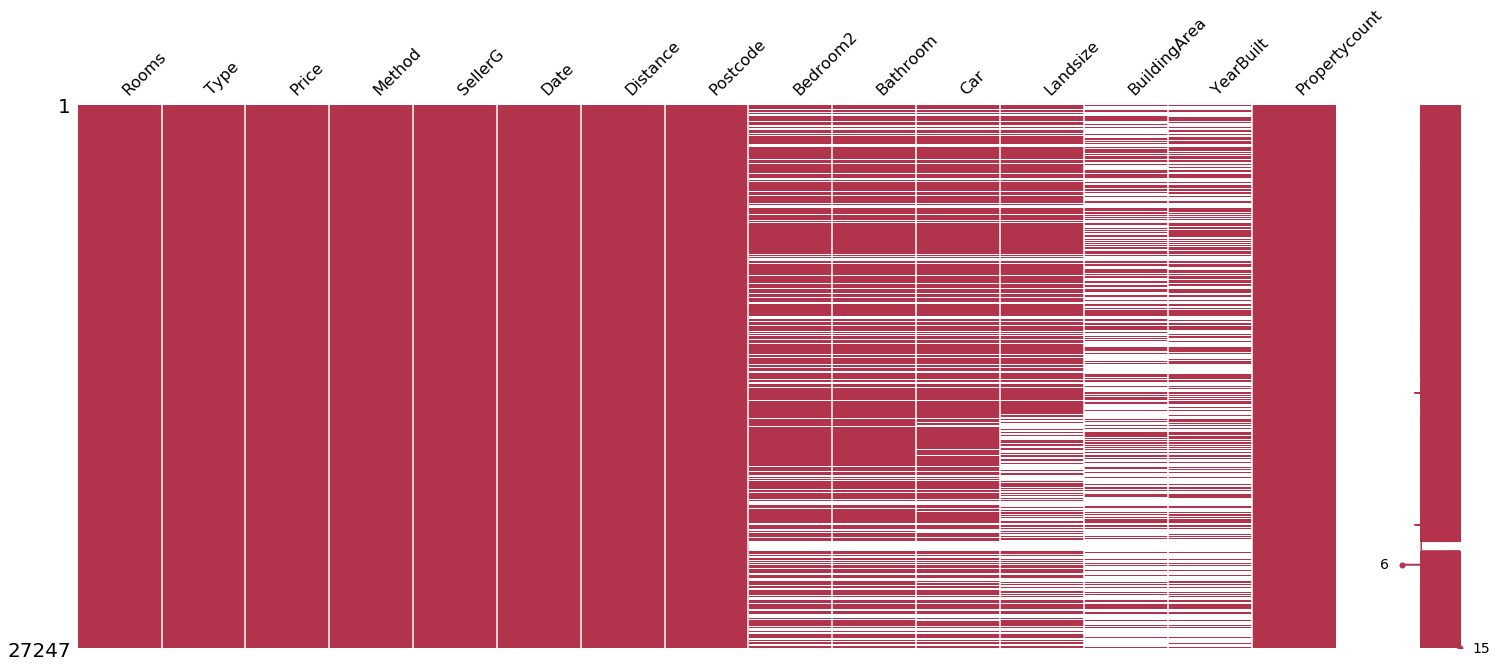

In [4]:
# check for missing data
msno.matrix(houseprice,color=(.7, .2, .3))
plt.show()

In [5]:
for col in houseprice.loc[:,'Bedroom2':'YearBuilt']:
    houseprice[col] = houseprice[col].fillna(houseprice[col].mean())
    
houseprice = houseprice.dropna()

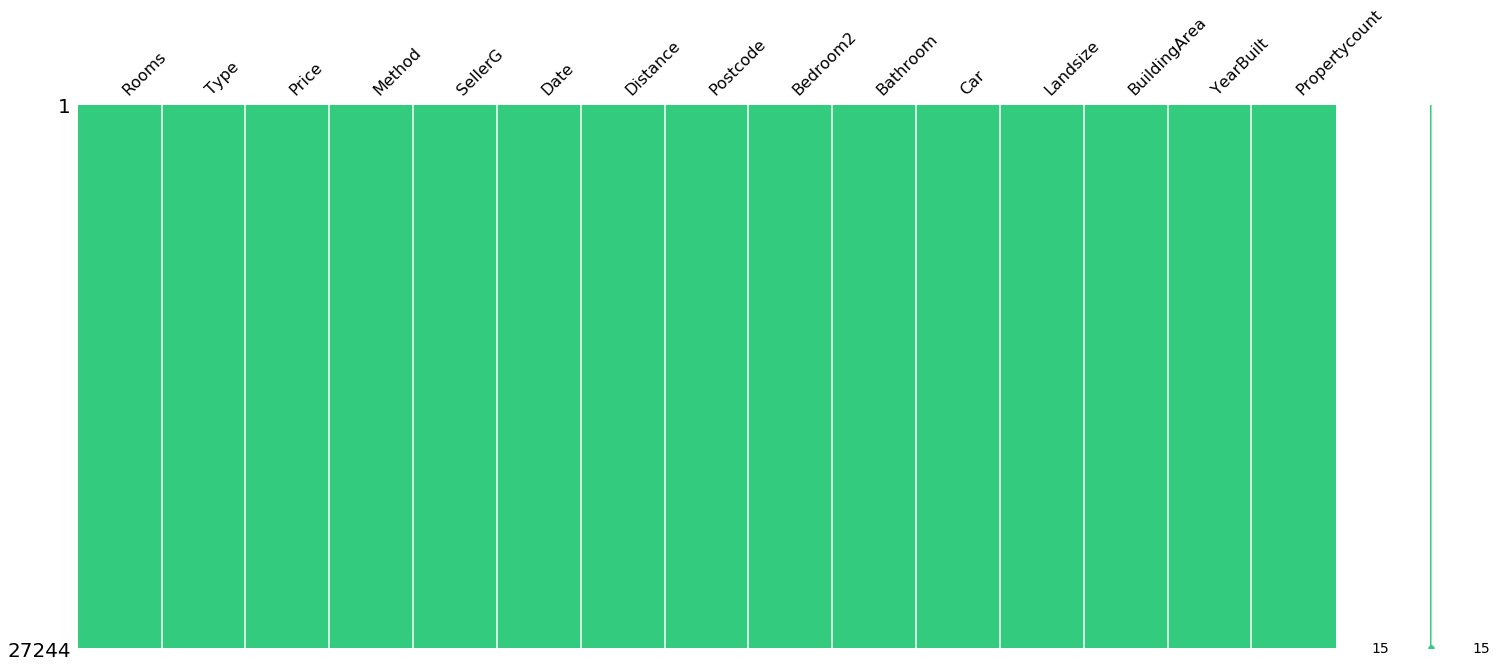

In [6]:
# check for missing data
msno.matrix(houseprice,color=(.2, .8, .5))
plt.show()

In [7]:
houseprice.head()

,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
1,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,156.834586,1966.609153,4019.0
2,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.000000,1900.000000,4019.0
4,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.000000,1900.000000,4019.0
5,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,156.834586,1966.609153,4019.0
6,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.000000,2014.000000,4019.0


In [8]:
houseprice.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27244 entries, 1 to 34856
Columns: 15 entries, Rooms to Propertycount
dtypes: float64(10), int64(1), object(4)

<a id="sec2"></a>

# <span style="color:darkblue">Exploring the Data</span>  <a href='#top'>(top)</a>

In [9]:
graph = houseprice[['Rooms', 'Price', 'Distance',
       'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'Propertycount']]

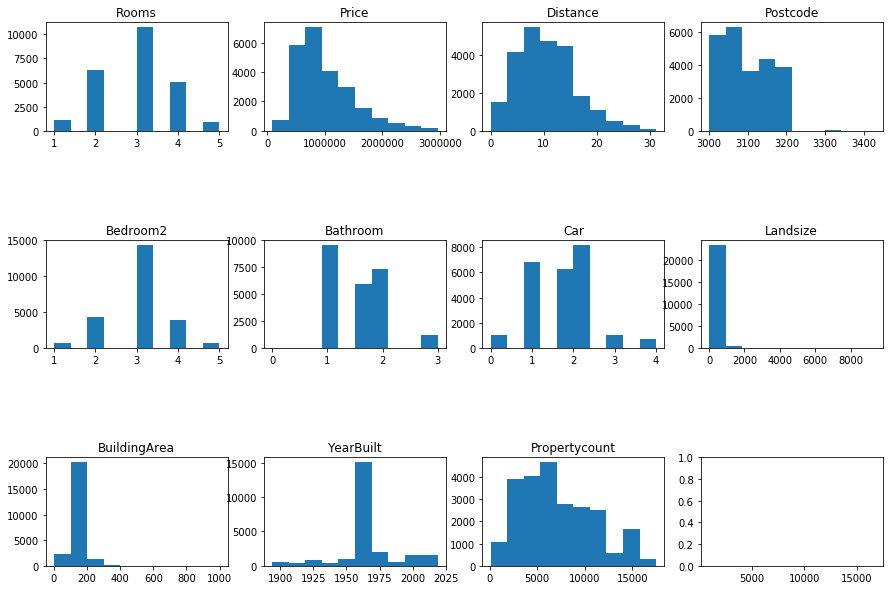

In [10]:
graph = houseprice[['Rooms', 'Price', 'Distance',
       'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'Propertycount']]
graph = graph[(np.abs(stats.zscore(graph)) < 3).all(axis=1)]

fig, axs = plt.subplots(3,4, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1)

axs = axs.ravel()

for i in range(11):
    axs[i].hist(graph.iloc[:,i])
    axs[i].set_title((graph.columns)[i])
    plt.xlim(xmax=graph.iloc[:,i].max(),xmin=graph.iloc[:,i].min())

In [11]:
houseprice.corr(method='spearman')

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
Rooms,1.000000,0.504304,0.347368,0.049034,0.726980,0.510911,0.430468,0.311626,0.384582,-0.003524,-0.073078
Price,0.504304,1.000000,-0.188137,0.215111,0.304773,0.310826,0.244493,0.174414,0.290461,-0.255964,-0.042439
Distance,0.347368,-0.188137,1.000000,0.265966,0.255360,0.167439,0.290923,0.321950,0.125463,0.195049,-0.089575
Postcode,0.049034,0.215111,0.265966,1.000000,0.067401,0.116928,0.062840,0.104722,0.074398,-0.000485,0.087485
Bedroom2,0.726980,0.304773,0.255360,0.067401,1.000000,0.563980,0.390034,0.403675,0.485594,-0.010206,-0.031546
Bathroom,0.510911,0.310826,0.167439,0.116928,0.563980,1.000000,0.373321,0.175322,0.408303,0.173397,-0.018494
Car,0.430468,0.244493,0.290923,0.062840,0.390034,0.373321,1.000000,0.323659,0.271523,0.082466,-0.024771
Landsize,0.311626,0.174414,0.321950,0.104722,0.403675,0.175322,0.323659,1.000000,0.264312,-0.060495,-0.039607
BuildingArea,0.384582,0.290461,0.125463,0.074398,0.485594,0.408303,0.271523,0.264312,1.000000,0.059386,-0.022433
YearBuilt,-0.003524,-0.255964,0.195049,-0.000485,-0.010206,0.173397,0.082466,-0.060495,0.059386,1.000000,0.013699


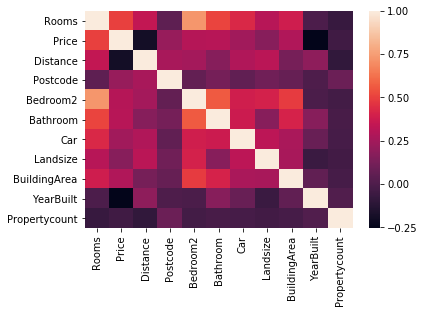

In [12]:
# calculate the correlation matrix (spearman is chosen because most features are not continuous)
corr = houseprice.corr(method='spearman')

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

_Second bedrooms seem to have the highest correllation to price_

<a id="sec3"></a>

# <span style="color:darkblue">Models:</span>  <a href='#top'>(top)</a>

In [31]:
houseprice.head()

,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
1,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,156.834586,1966.609153,4019.0
2,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.000000,1900.000000,4019.0
4,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.000000,1900.000000,4019.0
5,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,156.834586,1966.609153,4019.0
6,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.000000,2014.000000,4019.0


In [32]:
features = houseprice.copy()
# fType = pd.get_dummies(features.Type)
# fMethod = pd.get_dummies(features.Method)
# fSellerG = pd.get_dummies(features.SellerG)
del features['Type']
del features['Method']
del features['SellerG']
del features['Date']

In [27]:
features = pd.concat([features],axis=1)

In [33]:
y = features['Price'].values.reshape(-1, 1).ravel()
X = features.loc[:, ~features.columns.isin(['Price'])]

print(np.shape(y))
print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)  

(27244,)
(27244, 10)


In [34]:
X_train.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
17524,4,14.3,3109.0,4.000000,3.000000,2.00000,664.000000,156.834586,1966.609153,10999.0
7879,2,3.8,3207.0,1.000000,1.000000,0.00000,112.000000,156.834586,1966.609153,8648.0
15829,3,18.8,3170.0,3.000000,1.000000,1.00000,664.000000,156.834586,1966.609153,7113.0
31186,2,7.3,3146.0,3.046237,1.591683,1.71537,593.488933,156.834586,1966.609153,10412.0
6868,3,6.9,3039.0,3.000000,2.000000,1.00000,253.000000,156.834586,1966.609153,6232.0


<a id="seca"></a>

### <span style="color:darkblue">A. LR - Ordinary Least Squares</span>  <a href='#top'>(top)</a>

> Target is binary so this model may not be appropriate <br>Many features are binary so model may not be appropriate <br>Predicted values are not binary and need to be rounded up/down

In [35]:
%%capture timeA --no-stderr
%%time

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train, y_train)

In [36]:
regr.coef_

array([ 3.63327357e+05, -4.16584993e+04,  1.22749271e+03, -1.10929962e+05,
        2.05176510e+05,  5.62242076e+04,  4.04427217e+00,  6.20133758e+02,
       -4.97348790e+03, -3.65456474e+00])

In [37]:
# Display the attributes
print('Coefficients: \n')
pprint(list(zip(X.columns,regr.coef_)))
print('\nIntercept: \n', regr.intercept_)
coef = list(zip(X.columns,regr.coef_))

Coefficients: 

[('Rooms', 363327.35674942046),
 ('Distance', -41658.49930036836),
 ('Postcode', 1227.4927074320776),
 ('Bedroom2', -110929.96224697596),
 ('Bathroom', 205176.50959035536),
 ('Car', 56224.20757784966),
 ('Landsize', 4.044272167694989),
 ('BuildingArea', 620.1337584281251),
 ('YearBuilt', -4973.487899840654),
 ('Propertycount', -3.654564741210437)]

Intercept: 
 6236108.242964117


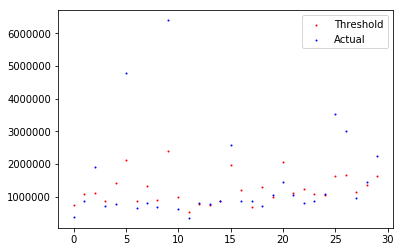

In [38]:
predY = regr.predict(X_test)
plt.scatter(range(len(y_test[0:30])),predY[0:30],c='red',s=1)
plt.scatter(range(len(y_test[0:30])),y_test[0:30],c='blue',s=1)
plt.legend(['Threshold','Actual','Predicted'],loc='upper right')
plt.show()

In [39]:
# score is low because of approximate values with lin regression - values need to be rounded
regr.score(X_test,y_test)

-0.01488053613760254

<a id="secb"></a>

### <span style="color:darkblue">B. LR - Logistic Regression</span>  <a href='#top'>(top)</a>

> Target is binary so logistic regression will operate on probabilities

In [ ]:
# %%capture timeB --no-stderr
# %%time

# # Instantiate our model.
# lregr = linear_model.LogisticRegression()

# # Fit our model to our data.
# lregr.fit(X_train, y_train)

In [ ]:
# lregr.coef_

In [ ]:
# # Display the attributes
# print('Coefficients: \n')
# pprint(list(zip(X.columns,lregr.coef_[0])))
# print('\nIntercept: \n', lregr.intercept_)
# coef = list(zip(X.columns,lregr.coef_[0]))

In [ ]:
# print(lregr.score(X_test,y_test))
# scoreB = lregr.score(X_test,y_test)

In [ ]:
# lregr.score(X_test,y_test)

<a id="secb1"></a>

#### <span style="color:darkred">B1. Lasso</span>  <a href='#top'>(top)</a>

In [ ]:
# lamvalues = [.1,.25,.5,.75,1,3,5,10]

# for lam in lamvalues:
#     # Instantiate our model.
#     lasso = linear_model.Lasso(alpha=lam,fit_intercept=False)
    
#     # Fit our model to our data.
#     lasso.fit(X_train, y_train)
    
#     print('\u03bb={} \tLasso Score: {}'.format(lam, lasso.score(X_test,y_test)))

<a id="secb2"></a>

#### <span style="color:darkred">B2. Ridge</span>  <a href='#top'>(top)</a>

In [ ]:
lamvalues = [.1,.5,.75,1,3,5,10]

for lam in lamvalues:
    # Instantiate our model.
    ridg = linear_model.Ridge(alpha=lam,fit_intercept=False)
    
    # Fit our model to our data.
    ridg.fit(X_train, y_train)
    
    print('\u03bb={} \tRidge Score: {}'.format(lam, ridg.score(X_test,y_test)))

_Lasso and Ridge are not good predictors so should I just be using them for parameter manipulation?_

<a id="secc"></a>

### <span style="color:darkblue">C. K Nearest Neighbors</span>  <a href='#top'>(top)</a>

> Can handle discrete values for target <br>Quantitative values are limited (not continuous) and might be problematic for nearest neighbors

In [40]:
%%capture timeC --no-stderr
%%time
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train.ravel())

In [41]:
print(neighbors.score(X_test,y_test))
scoreC = neighbors.score(X_test,y_test)

0.006361634450697333


<a id="secc"></a>

### <span style="color:darkblue">D. Naive Bayes - Bernoulli</span>  <a href='#top'>(top)</a>

> Should be best for boolean classification but has lowest prediction score

In [42]:
%%capture timeD --no-stderr
%%time
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

In [43]:
print(bnb.score(X_test,y_test))
scoreD = bnb.score(X_test,y_test)

0.009787129924149743


<a id="sece"></a>

### <span style="color:darkblue">E. Decision Tree</span>  <a href='#top'>(top)</a>

> Visualizes most important features by hierarchy <br>Longer processing time

In [ ]:
%%capture timeE --no-stderr
%%time

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3)

decision_tree.fit(X_train, y_train)

In [ ]:
# # Render our tree.
# dot_data = tree.export_graphviz(
#     decision_tree, out_file=None,
#     feature_names=X.columns,
#     filled=True
# )

# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

In [ ]:
scoreE=decision_tree.score(X_test,y_test)
decision_tree.score(X_test,y_test)

_Good visualization of important features and presentation of entropy weighting_

<a id="secf"></a>

### <span style="color:darkblue">F. Random Forest</span>  <a href='#top'>(top)</a>

> Runs decision tree multiple times for best output <br>Longest processing time

In [44]:
%%capture timeF --no-stderr
%%time

rfc = ensemble.RandomForestClassifier(n_estimators=20)
rfc.fit(X_train,y_train.ravel())

In [45]:
cvs = cross_val_score(rfc, X_test, y_test.ravel(), cv=5)
print(cvs)
scoreF = cvs.sum()/len(cvs)

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[0.00384369 0.0032967  0.0107362  0.01142857 0.00911162]


In [46]:
rfc.score(X_train,y_train)

0.7980308330094572

In [47]:
rfc.feature_importances_
importance = list(zip(X.columns,rfc.feature_importances_))

<a id="sec4"></a>

# <span style="color:darkblue">4. Model Comparison</span>  <a href='#top'>(top)</a>

In [ ]:
print('OLS Coefficients:')
pprint(coef)
print('\nDecision Tree Importance:')
pprint(importance)

In [ ]:
models = ['Ordinary Least Squares','Logistic Regression','K Nearest Neigbbors','Naive Bayes Bernoulli','Decision Tree','Random Forest']
times = [timeA,timeB,timeC,timeD,timeE,timeF]
timesfinal = []
for time in times:
    timesfinal.append((((time.stdout.splitlines())[0].split(','))[0].split('user '))[1])
score = [str(scoreA)[0:7]+('*'),scoreB,scoreC,scoreD,scoreE,scoreF]

dfModels = pd.DataFrame(index=models)
dfModels['cpu time'] = timesfinal
dfModels['score'] = score
dfModels

_Q. Why is Naive Bayes so low?_

_Q. How to handle discrete values (dummy values doesn't work)_